# Dengue Outbreak Detection Using LSTM Autoencoder
Prepared by: Hieng MAO

In [1]:
!nvidia-smi

Fri May  2 01:50:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.04             Driver Version: 570.124.04     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|


|   0  NVIDIA A40                     Off |   00000000:CA:00.0 Off |                    0 |
|  0%   54C    P0             83W /  300W |   41861MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+------------------------+----------------------+
                                                                                         
+-----------------------------------------------------------------------------------------+
| Processes:                                                                              |
|  GPU   GI   CI              PID   Type   Process name                        GPU Memory |
|        ID   ID                                                               Usage      |
|=========================================================================================|
|    0   N/A  N/A          418422      C   ...conda3/envs/vits_2/bin/python       

In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

In [36]:
MODEL_FILE_NAME = 'dengue_outbreak_detection2'
RANDOM_SEED = 42

## Dataset

In [5]:
df = pd.read_csv('dengue-2013-2023.csv')

print(df.head())

  Disease  Year PROVINCE  Week_no  Count
0  Dengue  2013  Bangkok        1    351
1  Dengue  2013  Bangkok        2    399
2  Dengue  2013  Bangkok        3    300
3  Dengue  2013  Bangkok        4    280
4  Dengue  2013  Bangkok        5    262


### Preprocessing

In [6]:
# Only keep relevant columns
df = df[['Year', 'PROVINCE', 'Week_no', 'Count']]

In [7]:
print(df.head())
print(df.describe())
print(df.info())

   Year PROVINCE  Week_no  Count
0  2013  Bangkok        1    351
1  2013  Bangkok        2    399
2  2013  Bangkok        3    300
3  2013  Bangkok        4    280
4  2013  Bangkok        5    262
               Year       Week_no         Count
count  43389.000000  43389.000000  43389.000000
mean    2017.896126     26.207518     21.276107
std        3.117756     14.929032     50.750883
min     2013.000000      1.000000      0.000000
25%     2015.000000     13.000000      2.000000
50%     2018.000000     26.000000      7.000000
75%     2021.000000     39.000000     21.000000
max     2023.000000     53.000000   2166.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43389 entries, 0 to 43388
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Year      43389 non-null  int64 
 1   PROVINCE  43389 non-null  object
 2   Week_no   43389 non-null  int64 
 3   Count     43389 non-null  int64 
dtypes: int64(3), object(1)
memory

In [9]:
# Count all cases by province
df_province = df.groupby('PROVINCE')['Count'].sum().sort_values(ascending=False).reset_index()
print("Top 10 Provinces with Most Cases:")
print(df_province.head(10))

Top 10 Provinces with Most Cases:
              PROVINCE   Count
0              Bangkok  109244
1           Chiang Mai   42376
2    Nakhon Ratchasima   41708
3           Chiang Rai   35968
4             Songkhla   30365
5     Ubon Ratchathani   29365
6  Nakhon Si Thammarat   27060
7                Surin   23976
8             Chonburi   23701
9               Rayong   20426


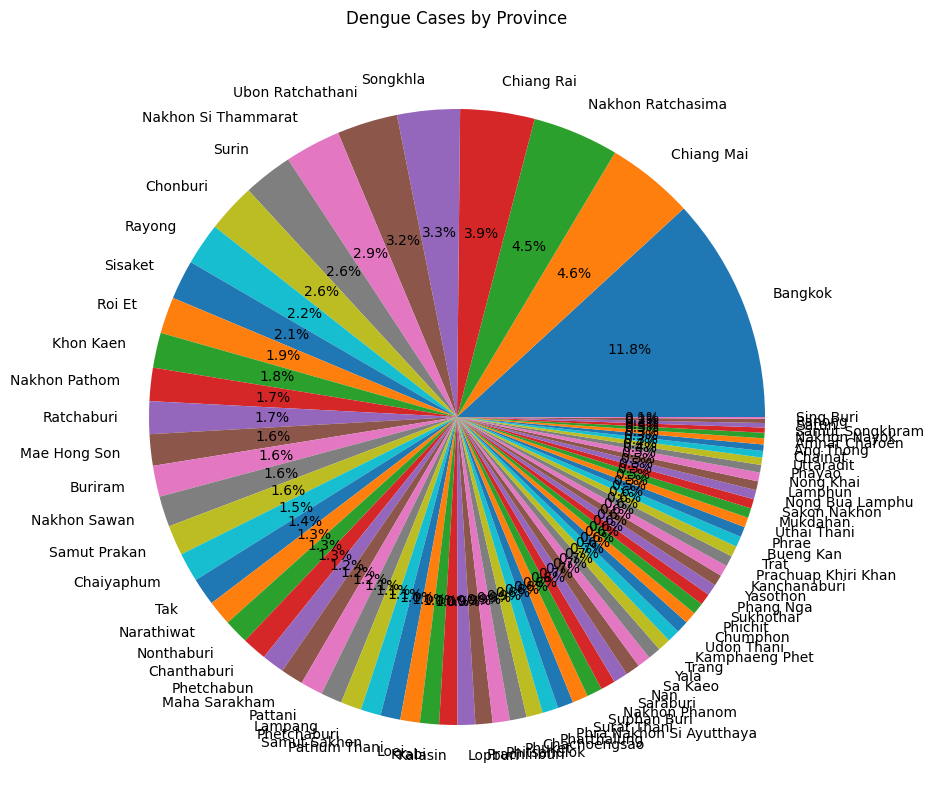

In [140]:
df_province.set_index('PROVINCE')['Count'].plot.pie(autopct='%1.1f%%', figsize=(10, 10))
plt.ylabel('')  # Hide the y-label
plt.title('Dengue Cases by Province')
plt.show()


In [10]:
print(df_province.describe())
print(df_province['Count'].sum())

               Count
count      77.000000
mean    11988.948052
std     14201.908752
min       883.000000
25%      5206.000000
50%      7900.000000
75%     14067.000000
max    109244.000000
923149


In [11]:
# Keep the original dataframe but have it sorted based on the total count per province
df['Total_Count'] = df['PROVINCE'].map(df_province.set_index('PROVINCE')['Count'])
df_sorted = df.sort_values(by='Total_Count', ascending=False).reset_index(drop=True)
df_sorted.head()

Year PROVINCE  Week_no  Count  Total_Count
0  2013  Bangkok       51    199       109244
1  2018  Bangkok        1    142       109244
2  2013  Bangkok        5    262       109244
3  2013  Bangkok       26    285       109244
4  2013  Bangkok       27    347       109244

In [12]:
# Re-assign back to dataframe
df = df_sorted[['Year', 'PROVINCE', 'Week_no', 'Count']]
df.head()

Year PROVINCE  Week_no  Count
0  2013  Bangkok       51    199
1  2018  Bangkok        1    142
2  2013  Bangkok        5    262
3  2013  Bangkok       26    285
4  2013  Bangkok       27    347

### Selecting a Threshold for Training (Normal) and Testing (Abnormal) Dataset
Selecting a Count's threshold is crucial for this work. We classify the data as Normal for training set and Abnormal for the testing.

In [ ]:
COUNT_THRESHOLD = 100

In [135]:
def plot_dengue(df, count_threshold=100, title='Dengue Cases by Province'):
    # Plotting the data
    plt.figure(figsize=(16, 12))
    sns.set_theme(style="whitegrid")
    sns.lineplot(data=df, x='Week_no', y='Count', hue='PROVINCE', palette='tab10') 
    # Add a dot lines for a threshold
    plt.axhline(y=count_threshold, color='r', linestyle='--', label=f'Threshold ({count_threshold})')
    plt.title(title)
    plt.xlabel('Week Number')
    plt.ylabel('Count')
    plt.legend(title='Province')
    plt.show()

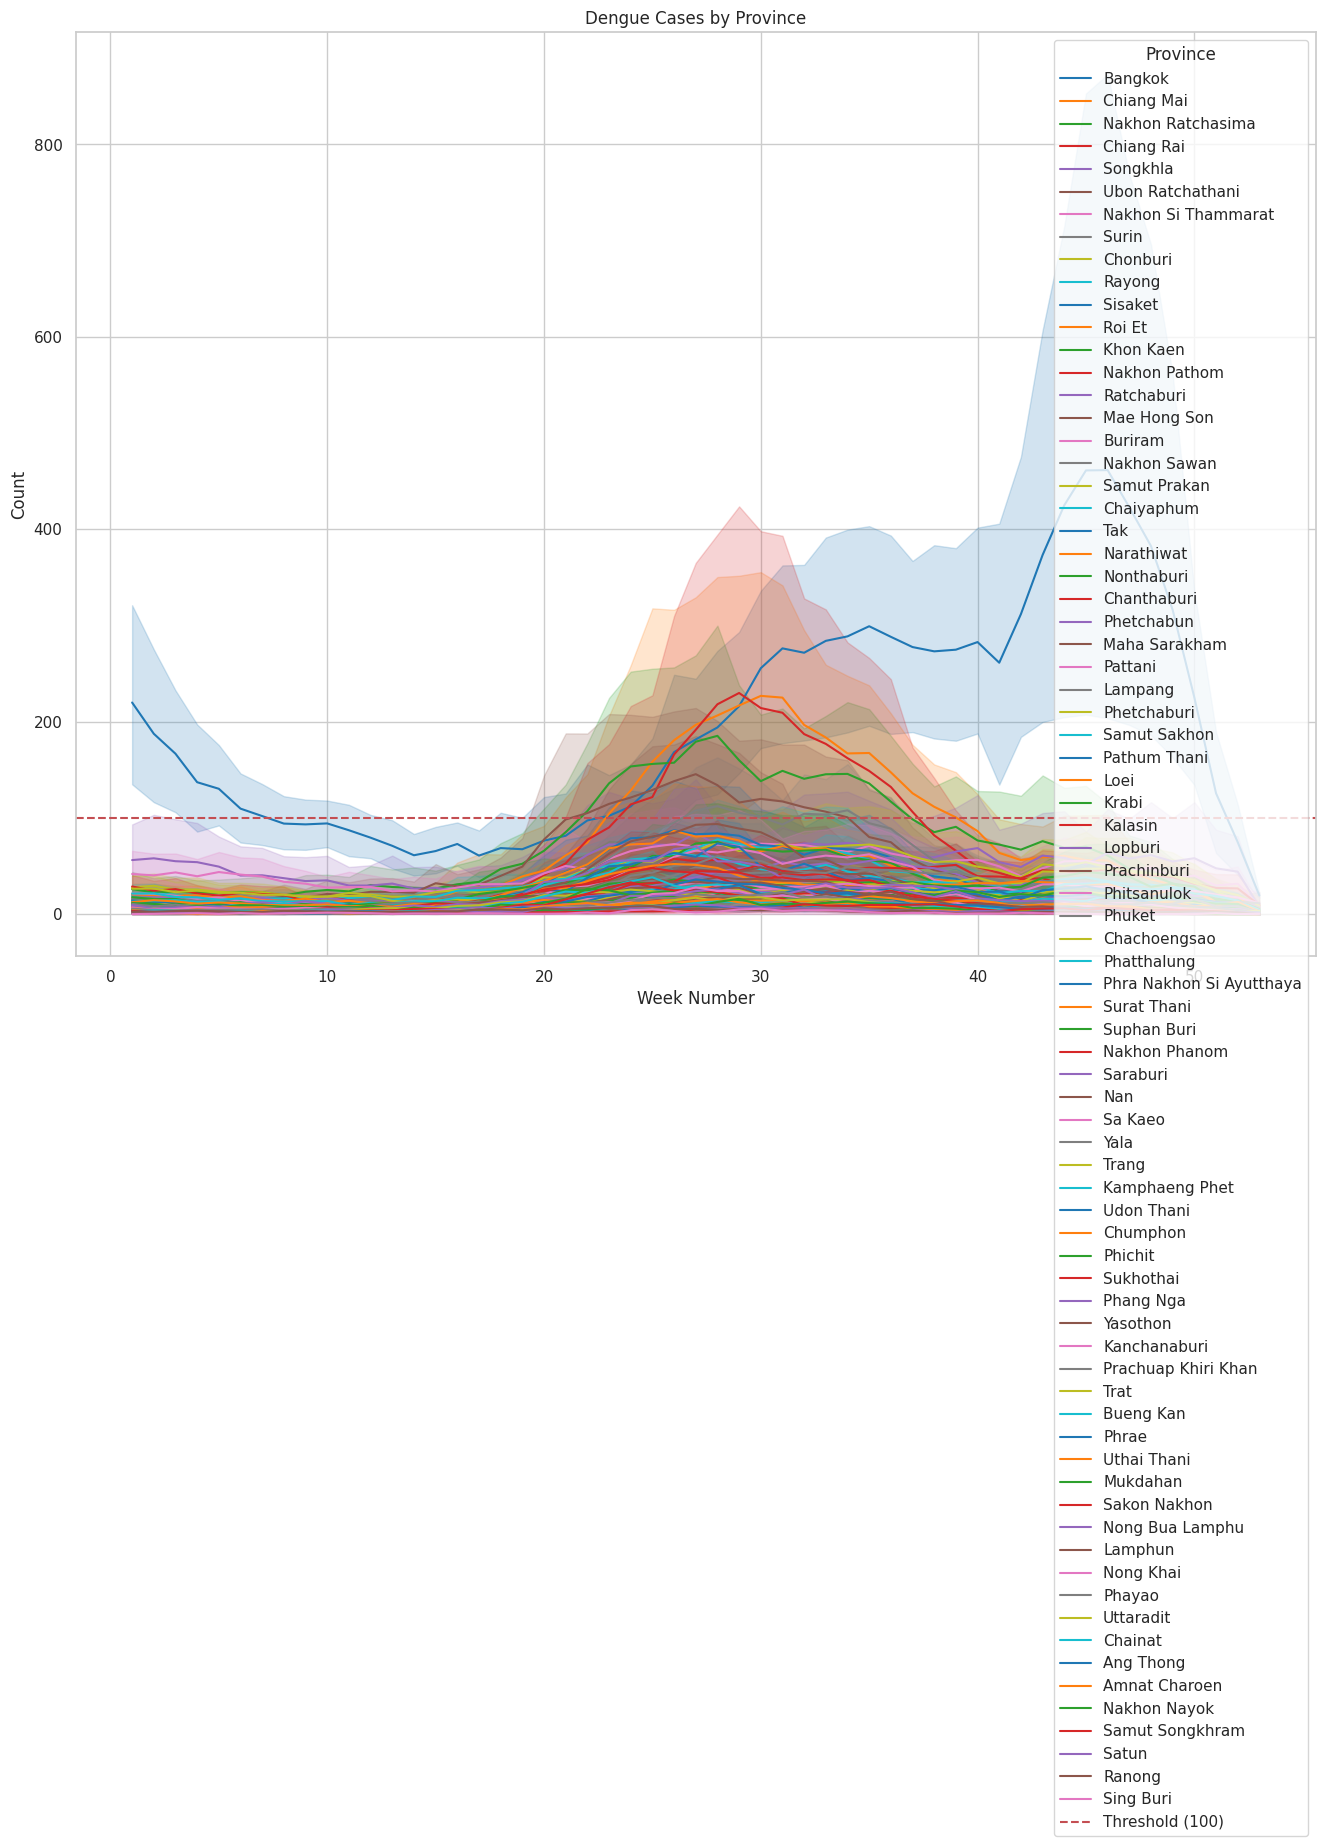

In [115]:
plot_dengue(df, COUNT_THRESHOLD)

**Insights**
- By looking the graph, we can see that the hight number of dengue counts happen mostly between **week 25 to 32 for most provinces**. This indicate that the warning of the dengue should start between these weeks.
- We can draw/pick a **Count Threshold** to define that the value below the threshold counted as **NORMAL**, since the above threshold counted as **ABNORMAL**.

In [ ]:
# province_order = df_province['PROVINCE'].tolist()
# print(province_order)

In [ ]:
# # Convert PROVINCE to a categorical type with ordered categories
# df.loc[:, 'PROVINCE'] = pd.Categorical(df['PROVINCE'], categories=province_order, ordered=True)

# # Now sort by PROVINCE (preserving order), then Year, then Week_no
# df = df.sort_values(by=['PROVINCE', 'Year', 'Week_no'])

# df.head()

Most Affected Province: Bangkok between 2013 and 2023
<class 'pandas.core.frame.DataFrame'>
Index: 563 entries, 0 to 562
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Year      563 non-null    int64 
 1   PROVINCE  563 non-null    object
 2   Week_no   563 non-null    int64 
 3   Count     563 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 22.0+ KB
None


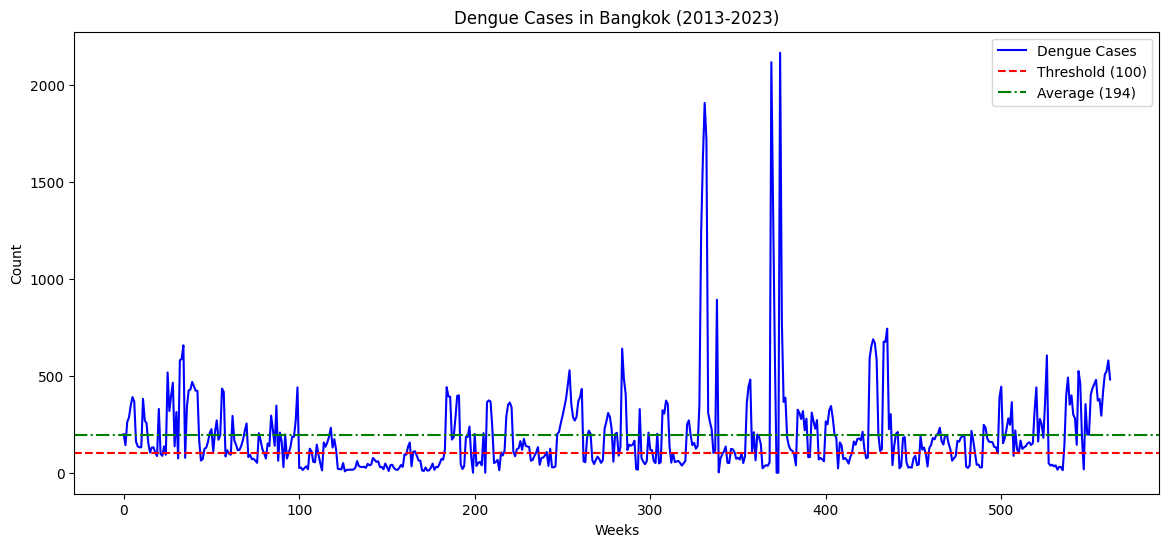

In [11]:
# Visualize the most affected province
most_affected_province = df_province.iloc[0]['PROVINCE']
most_affected_df = df[df['PROVINCE'] == most_affected_province]
min_year, max_year = most_affected_df['Year'].min(), most_affected_df['Year'].max()

print(f"Most Affected Province: {most_affected_province} between {min_year} and {max_year}")
print(most_affected_df.info())

plt.figure(figsize=(14,6))
plt.plot(most_affected_df['Count'].values, label='Dengue Cases', color='blue')

# Add a dot lines for a threshold
plt.axhline(y=COUNT_THRESHOLD, color='r', linestyle='--', label=f'Threshold ({COUNT_THRESHOLD})')

# Add a dot line for the average
avg = most_affected_df['Count'].mean().round().astype(int)
plt.axhline(y=avg, color='g', linestyle='-.', label=f'Average ({avg})')
# Add alert threshold
# alert_threshold = 550
# plt.axhline(y=alert_threshold, color='orange', linestyle='--', label=f'Alert Threshold ({alert_threshold})')
# Optional: Fill the area above the alert threshold
# plt.fill_between(range(len(most_affected_df)), alert_threshold, most_affected_df['Count'].values, where=(most_affected_df['Count'].values > alert_threshold), color='orange', alpha=0.3)
plt.title(f'Dengue Cases in {most_affected_province} ({min_year}-{max_year})')
plt.xlabel('Weeks')
plt.ylabel('Count')
plt.legend()
plt.show()

### Data Scaling & Splitting

We scale the data before further splitting:

In [16]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
scaled_df = df.copy()
scaled_df['PROVINCE'] = le.fit_transform(scaled_df['PROVINCE'])

scaled_df.head()

Year  PROVINCE  Week_no  Count
0  2013         2       51    199
1  2018         2        1    142
2  2013         2        5    262
3  2013         2       26    285
4  2013         2       27    347

In [17]:
province_code_mapping = dict(zip(le.transform(le.classes_), le.classes_))
print(province_code_mapping)

{0: 'Amnat Charoen', 1: 'Ang Thong', 2: 'Bangkok', 3: 'Bueng Kan', 4: 'Buriram', 5: 'Chachoengsao', 6: 'Chainat', 7: 'Chaiyaphum', 8: 'Chanthaburi', 9: 'Chiang Mai', 10: 'Chiang Rai', 11: 'Chonburi', 12: 'Chumphon', 13: 'Kalasin', 14: 'Kamphaeng Phet', 15: 'Kanchanaburi', 16: 'Khon Kaen', 17: 'Krabi', 18: 'Lampang', 19: 'Lamphun', 20: 'Loei', 21: 'Lopburi', 22: 'Mae Hong Son', 23: 'Maha Sarakham', 24: 'Mukdahan', 25: 'Nakhon Nayok', 26: 'Nakhon Pathom', 27: 'Nakhon Phanom', 28: 'Nakhon Ratchasima', 29: 'Nakhon Sawan', 30: 'Nakhon Si Thammarat', 31: 'Nan', 32: 'Narathiwat', 33: 'Nong Bua Lamphu', 34: 'Nong Khai', 35: 'Nonthaburi', 36: 'Pathum Thani', 37: 'Pattani', 38: 'Phang Nga', 39: 'Phatthalung', 40: 'Phayao', 41: 'Phetchabun', 42: 'Phetchaburi', 43: 'Phichit', 44: 'Phitsanulok', 45: 'Phra Nakhon Si Ayutthaya', 46: 'Phrae', 47: 'Phuket', 48: 'Prachinburi', 49: 'Prachuap Khiri Khan', 50: 'Ranong', 51: 'Ratchaburi', 52: 'Rayong', 53: 'Roi Et', 54: 'Sa Kaeo', 55: 'Sakon Nakhon', 56: 'S

We Split data for Normal and Abnormal.

In [18]:
normal_df = scaled_df[scaled_df['Count'] <= COUNT_THRESHOLD]
abnormal_df = scaled_df[scaled_df['Count'] > COUNT_THRESHOLD]
print(f"Normal Dataframe Shape: {normal_df.shape}")
print(f"Abnormal Dataframe Shape: {abnormal_df.shape}")
print(f"Normal Dataframe Percentage: {normal_df.shape[0] / scaled_df.shape[0] * 100:.2f}%")
print(f"Abnormal Dataframe Percentage: {abnormal_df.shape[0] / scaled_df.shape[0] * 100:.2f}%")

Normal Dataframe Shape: (41802, 4)
Abnormal Dataframe Shape: (1587, 4)
Normal Dataframe Percentage: 96.34%
Abnormal Dataframe Percentage: 3.66%


We further scale the data using MinMaxScaler:

In [19]:
from sklearn.preprocessing import MinMaxScaler

scaled_normal_df = normal_df.copy()
scaled_abnormal_df = abnormal_df.copy()

scaler = MinMaxScaler()
scaled_normal_df[['Year', 'PROVINCE', 'Week_no', 'Count']] = scaler.fit_transform(scaled_normal_df[['Year', 'PROVINCE', 'Week_no', 'Count']])
scaled_abnormal_df[['Year', 'PROVINCE', 'Week_no', 'Count']] = scaler.transform(scaled_abnormal_df[['Year', 'PROVINCE', 'Week_no', 'Count']])
print(scaled_normal_df.head())
print(scaled_abnormal_df.head())

    Year  PROVINCE   Week_no  Count
19   1.0  0.026316  0.288462   0.86
21   0.5  0.026316  0.019231   0.97
22   0.5  0.026316  0.038462   0.87
24   0.5  0.026316  0.115385   0.93
31   0.4  0.026316  0.288462   0.74
   Year  PROVINCE   Week_no  Count
0   0.0  0.026316  0.961538   1.99
1   0.5  0.026316  0.000000   1.42
2   0.0  0.026316  0.076923   2.62
3   0.0  0.026316  0.480769   2.85
4   0.0  0.026316  0.500000   3.47


We'll split the normal examples into train, validation and test sets:

In [21]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
  scaled_normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33, 
  random_state=RANDOM_SEED
)

print(f"Train Dataframe Shape: {train_df.shape}")
print(f"Validation Dataframe Shape: {val_df.shape}")
print(f"Test Dataframe Shape: {test_df.shape}")
print(train_df.head(10))

Train Dataframe Shape: (35531, 4)
Validation Dataframe Shape: (4201, 4)
Test Dataframe Shape: (2070, 4)
       Year  PROVINCE   Week_no  Count
13854   0.3  0.539474  0.711538   0.07
6673    0.7  0.697368  0.442308   0.52
29545   0.4  0.565789  0.019231   0.02
18936   0.8  0.171053  0.596154   0.08
37386   0.6  0.447368  0.923077   0.00
6810    0.9  0.210526  0.769231   0.11
8109    0.2  0.671053  0.096154   0.24
22461   0.8  0.513158  0.980769   0.02
27624   0.2  0.184211  0.192308   0.04
24630   0.8  0.355263  0.403846   0.02


We need to convert our examples into tensors, so we can use them to train our Autoencoder. Let's write a helper function for that:

In [23]:
TIME_STEPS = 4

In [25]:
# Check how data sequence look like for training/testing the model
sample_length = 10
# sample_data_sequence = []
for i in range(sample_length - TIME_STEPS + 1):
    seq = train_df.iloc[i:i+TIME_STEPS].values
    print(seq)

# print(sample_data_sequence)

[[0.3        0.53947368 0.71153846 0.07      ]
 [0.7        0.69736842 0.44230769 0.52      ]
 [0.4        0.56578947 0.01923077 0.02      ]
 [0.8        0.17105263 0.59615385 0.08      ]]
[[0.7        0.69736842 0.44230769 0.52      ]
 [0.4        0.56578947 0.01923077 0.02      ]
 [0.8        0.17105263 0.59615385 0.08      ]
 [0.6        0.44736842 0.92307692 0.        ]]
[[0.4        0.56578947 0.01923077 0.02      ]
 [0.8        0.17105263 0.59615385 0.08      ]
 [0.6        0.44736842 0.92307692 0.        ]
 [0.9        0.21052632 0.76923077 0.11      ]]
[[0.8        0.17105263 0.59615385 0.08      ]
 [0.6        0.44736842 0.92307692 0.        ]
 [0.9        0.21052632 0.76923077 0.11      ]
 [0.2        0.67105263 0.09615385 0.24      ]]
[[0.6        0.44736842 0.92307692 0.        ]
 [0.9        0.21052632 0.76923077 0.11      ]
 [0.2        0.67105263 0.09615385 0.24      ]
 [0.8        0.51315789 0.98076923 0.02      ]]
[[0.9        0.21052632 0.76923077 0.11      ]
 [0.2   

In [27]:
import torch

# Each Time Series will be converted to a 2D Tensor in the shape sequence length x number of features
# The number of features is 4 (Year, Province, Week_no, Count)
# The sequence length is the number of weeks in the time series
def create_dataset(df, sequence_length=4):
  """
  Create a dataset from the dataframe
  Args:
    df: DataFrame containing the data
    sequence_length: Length of the sequence to create
  Returns:
    sequences: Tensor containing the sequences
  """
  sequences = []
  for i in range(len(df) - sequence_length + 1):
    seq = df.iloc[i:i + sequence_length].values
    sequences.append(seq)

  sequence_np = np.array(sequences)
  return torch.tensor(sequence_np, dtype=torch.float32).to(device)

train_sequences = create_dataset(train_df, TIME_STEPS)
val_sequences = create_dataset(val_df, TIME_STEPS)
test_sequences = create_dataset(test_df, TIME_STEPS)
test_abnormal_sequences = create_dataset(scaled_abnormal_df, TIME_STEPS)

print(f"Train Sequences Shape: {train_sequences.shape}")
print(f"Validation Sequences Shape: {val_sequences.shape}")
print(f"Test Sequences Shape: {test_sequences.shape}")
print(f"Test Abnormal Sequences Shape: {test_abnormal_sequences.shape}")
print(train_sequences[0])
print(train_sequences[1])
print(train_sequences[2])

Train Sequences Shape: torch.Size([35528, 4, 4])
Validation Sequences Shape: torch.Size([4198, 4, 4])
Test Sequences Shape: torch.Size([2067, 4, 4])
Test Abnormal Sequences Shape: torch.Size([1584, 4, 4])
tensor([[0.3000, 0.5395, 0.7115, 0.0700],
        [0.7000, 0.6974, 0.4423, 0.5200],
        [0.4000, 0.5658, 0.0192, 0.0200],
        [0.8000, 0.1711, 0.5962, 0.0800]], device='cuda:0')
tensor([[0.7000, 0.6974, 0.4423, 0.5200],
        [0.4000, 0.5658, 0.0192, 0.0200],
        [0.8000, 0.1711, 0.5962, 0.0800],
        [0.6000, 0.4474, 0.9231, 0.0000]], device='cuda:0')
tensor([[0.4000, 0.5658, 0.0192, 0.0200],
        [0.8000, 0.1711, 0.5962, 0.0800],
        [0.6000, 0.4474, 0.9231, 0.0000],
        [0.9000, 0.2105, 0.7692, 0.1100]], device='cuda:0')


In [119]:
def reverse_windowing(sequences, seq_length=4):
    """
    This function used to reverse back the creating dataset for model training.
    """
    sequences_data = torch.cat((sequences[0], sequences[1:, -1, :]))
    
    return sequences_data

In [121]:
reversed_train_seq = reverse_windowing(train_sequences)
print(reversed_train_seq[:6])

tensor([[0.3000, 0.5395, 0.7115, 0.0700],
        [0.7000, 0.6974, 0.4423, 0.5200],
        [0.4000, 0.5658, 0.0192, 0.0200],
        [0.8000, 0.1711, 0.5962, 0.0800],
        [0.6000, 0.4474, 0.9231, 0.0000],
        [0.9000, 0.2105, 0.7692, 0.1100]], device='cuda:0')


## Model Architecture
[Reference](https://github.com/curiousily/Getting-Things-Done-with-Pytorch/blob/master/06.time-series-anomaly-detection-ecg.ipynb) 

In [28]:
from torch import nn

class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()
        self.seq_len = seq_len
        self.n_features = n_features
        self.embedding_dim = embedding_dim
        self.hidden_dim = 2 * embedding_dim

        self.rnn1 = nn.LSTM(
            input_size=n_features,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
        )

        self.rnn2 = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=embedding_dim,
            num_layers=1,
            batch_first=True
        )

    def forward(self, x):  # x: (batch, seq_len, n_features)
        x, _ = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)
        return hidden_n[-1]  # shape: (batch, embedding_dim)

The Encoder uses two LSTM layers to compress the Time Series data input.

In [29]:
from torch import nn

class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=4):
        super(Decoder, self).__init__()
        self.seq_len = seq_len
        self.input_dim = input_dim
        self.hidden_dim = 2 * input_dim
        self.n_features = n_features

        self.rnn1 = nn.LSTM(
            input_size=input_dim,
            hidden_size=input_dim,
            num_layers=1,
            batch_first=True
        )

        self.rnn2 = nn.LSTM(
            input_size=input_dim,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
        )

        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):  # x: (batch, input_dim)
        # Expand latent vector across time steps
        x = x.unsqueeze(1).repeat(1, self.seq_len, 1)  # (batch, seq_len, input_dim)

        x, _ = self.rnn1(x)
        x, _ = self.rnn2(x)

        return self.output_layer(x)  # (batch, seq_len, n_features)


Our Decoder contains two LSTM layers and an output layer that gives the final reconstruction.

Time to wrap everything into an easy to use module:

In [30]:
class RecurrentAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentAutoencoder, self).__init__()
        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [52]:
batch_size = 32
seq_len = TIME_STEPS
n_features = 4
embedding_dim = 64

In [ ]:
test_model = RecurrentAutoencoder(seq_len, n_features, embedding_dim).to(device)
dummy_input = torch.randn(batch_size, seq_len, n_features).to(device)

print("Input shape:", dummy_input.shape)
output = test_model(dummy_input)
print("Output shape:", output.shape)


Input shape: torch.Size([32, 4, 4])
Output shape: torch.Size([32, 4, 4])


In [33]:
model = RecurrentAutoencoder(seq_len, n_features, embedding_dim).to(device)
model = model.to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# criterion = nn.L1Loss(reduction='sum').to(device)
criterion = nn.MSELoss().to(device) # reduction='none' compute per-sample losses.

In [35]:
import copy 
from torch.utils.data import DataLoader, TensorDataset

def train_model(model, optimizer, criterion, train_dataset, val_dataset, n_epochs=50, batch_size=16):
  history = dict(train=[], val=[])

  # train_dataset = TensorDataset(train_sequences)  # wrap tensor in dataset
  # val_dataset = TensorDataset(val_sequences)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size)

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true_batch in train_loader:
      optimizer.zero_grad()

      seq_true = seq_true_batch.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true_batch in val_loader:

        seq_true = seq_true_batch.to(device)
        val_pred = model(seq_true)

        loss = criterion(val_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

Note that we're minimizing the [L1Loss](https://pytorch.org/docs/stable/nn.html#l1loss), which measures the **MAE (mean absolute error)**. Why? The reconstructions seem to be better than with **MSE (mean squared error)**.

In [ ]:
epochs = 10

In [38]:
model, history = train_model(model, optimizer, criterion, train_sequences, val_sequences, n_epochs=epochs)

Epoch 1: train loss 0.03294540724619797 val loss 0.004620575790024387
Epoch 2: train loss 0.0022480557584883087 val loss 0.0011506614486860402
Epoch 3: train loss 0.00031297697513224304 val loss 0.0002480427270995085
Epoch 4: train loss 0.0001476858234430195 val loss 0.00011475457515064698
Epoch 5: train loss 0.00011368391898153845 val loss 0.00017273420470296635
Epoch 6: train loss 9.946840310476137e-05 val loss 6.843820374895918e-05
Epoch 7: train loss 8.01520230429824e-05 val loss 9.352377574481849e-05
Epoch 8: train loss 7.216590742772512e-05 val loss 0.00010984078611374722
Epoch 9: train loss 6.196899902092066e-05 val loss 5.6341600338437065e-05
Epoch 10: train loss 5.659736625262935e-05 val loss 5.246342333047403e-05
Epoch 11: train loss 5.627789681854331e-05 val loss 4.416134453084481e-05
Epoch 12: train loss 4.588564508892687e-05 val loss 7.11379236699491e-05
Epoch 13: train loss 4.444525856736334e-05 val loss 3.689277645391049e-05
Epoch 14: train loss 4.232580896342431e-05 val

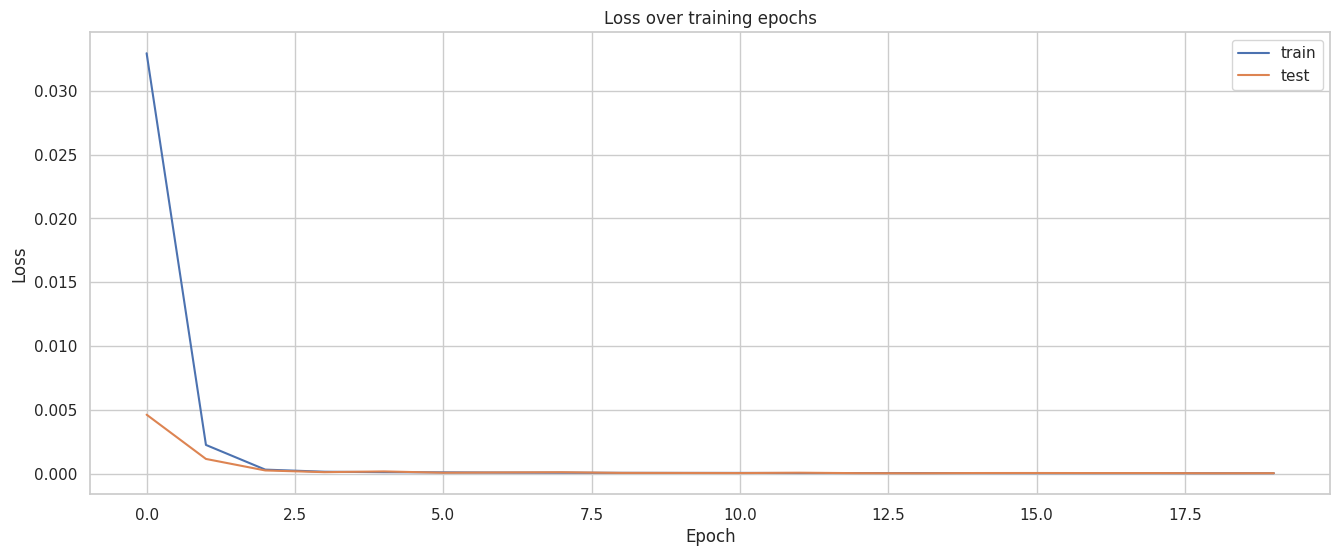

In [39]:
ax = plt.figure(figsize=(16,6)).gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

Our model converged quite well. The size of validation set make it smoothen well too. That'll do for now.

### Saving the model

In [40]:
# Save the model
filename = f'{MODEL_FILE_NAME}_{epochs}epochs_mse'
torch.save(model.state_dict(), f'{filename}.h5')

In [41]:
torch.save({
    'epoch': epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': history['train'],
    'val_loss': history['val']
}, f'cp_{filename}.pth')

### NORMAL Cases Prediction

In [26]:
model.load_state_dict(torch.load(MODEL_FILE_NAME))

<All keys matched successfully>

With our model at hand, we can have a look at the reconstruction error on the training set. Let's start by writing a helper function to get predictions from our model:

In [ ]:
from torch.utils.data import DataLoader
import torch.nn.functional as F  # For MSE loss with reduction='none'

def predict(model, criterion, dataset, batch_size=16):
  all_preds = []
  sample_losses = []
  # sample_losses2 = []

  data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
  model = model.eval()

  with torch.no_grad():
    for seq_true in data_loader:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      # First loss calculation
      # criterion returns shape [B, T, F] when reduction='none'
      loss_tensor = criterion(seq_pred, seq_true)  # [B, T, F]
      loss_per_sample = loss_tensor.mean(dim=(1, 2))  # Reduce per sample -> [B]

      sample_losses.append(loss_per_sample.cpu())
      
      # Second loss calculation
      # loss_per_sample_f = F.mse_loss(seq_pred, seq_true, reduction='none')  # [B, T, F]
      # loss_per_sample_f = loss_per_sample_f.mean(dim=(1, 2))  # Mean over time and features per sample -> [B]

      all_preds.append(seq_pred.cpu())
      # sample_losses2.append(loss_per_sample_f.cpu())

  # Concatenate all batches
    all_preds = torch.cat(all_preds, dim=0)      # Shape: [2067, 4, 4]
    sample_losses = torch.cat(sample_losses, dim=0).numpy()     # Shape: (2067,)
    # sample_losses2 = torch.cat(sample_losses2, dim=0)     # Shape: [2067]

  return all_preds, sample_losses #, sample_losses2

print("Input shape:", test_sequences.shape)
criterion2 = nn.MSELoss(reduction='none').to(device) # reduction='none' compute per-sample losses.
_, sample_losses = predict(model, criterion2, test_sequences, batch_size=batch_size)
print(sample_losses.shape)
print(sample_losses[:5])

Input shape: torch.Size([2067, 4, 4])
(2067,)
[1.5396705e-05 3.4317851e-05 2.0069489e-05 1.4643585e-05 2.0255677e-05]


In [181]:
print("Input sequence:")
print(train_sequences.shape)
print(train_sequences[:2])
train_predictions, train_losses = predict(model, criterion, train_sequences, batch_size=batch_size)
print("\nPredicted sequence:")
print(train_predictions.shape)
print(train_predictions[:3])
print(train_losses.shape)

Input sequence:
torch.Size([35528, 4, 4])
tensor([[[0.3000, 0.5395, 0.7115, 0.0700],
         [0.7000, 0.6974, 0.4423, 0.5200],
         [0.4000, 0.5658, 0.0192, 0.0200],
         [0.8000, 0.1711, 0.5962, 0.0800]],

        [[0.7000, 0.6974, 0.4423, 0.5200],
         [0.4000, 0.5658, 0.0192, 0.0200],
         [0.8000, 0.1711, 0.5962, 0.0800],
         [0.6000, 0.4474, 0.9231, 0.0000]]], device='cuda:0')

Predicted sequence:
torch.Size([35528, 4, 4])
tensor([[[ 0.3032,  0.5388,  0.7137,  0.0679],
         [ 0.6909,  0.7042,  0.4396,  0.5216],
         [ 0.4008,  0.5661,  0.0129,  0.0193],
         [ 0.8038,  0.1672,  0.6036,  0.0743]],

        [[ 0.7045,  0.6963,  0.4412,  0.5132],
         [ 0.4011,  0.5676,  0.0234,  0.0236],
         [ 0.8068,  0.1617,  0.6002,  0.0813],
         [ 0.6047,  0.4492,  0.9227, -0.0025]],

        [[ 0.4031,  0.5596,  0.0147,  0.0150],
         [ 0.7982,  0.1703,  0.6061,  0.0784],
         [ 0.6009,  0.4467,  0.9235,  0.0031],
         [ 0.9063,  0.209

In [178]:
# Sliding windows 4x4 Back to get the synthetic data
print(train_predictions[0])
print(train_predictions[1:3, -1, :])
print()
train_synthetic_data = torch.cat((train_predictions[0], train_predictions[1:, -1, :]))
print(train_synthetic_data[:6])

print()
train_synthetic_data = scaler.inverse_transform(train_synthetic_data)
train_synthetic_df = pd.DataFrame(train_synthetic_data, columns=['Year', 'PROVINCE', 'Week_no', 'Count'])

train_synthetic_df[['PROVINCE', 'Year', 'Week_no', 'Count']] = train_synthetic_df[['PROVINCE', 'Year', 'Week_no', 'Count']].round().astype(int)
# Map back the encoded province names
# train_synthetic_df['PROVINCE'] = train_synthetic_df['PROVINCE'].apply(lambda x: province_code_mapping.get(int(x), 'Unknown'))
print(train_synthetic_df.head())

tensor([[0.3032, 0.5388, 0.7137, 0.0679],
        [0.6909, 0.7042, 0.4396, 0.5216],
        [0.4008, 0.5661, 0.0129, 0.0193],
        [0.8038, 0.1672, 0.6036, 0.0743]])
tensor([[ 0.6047,  0.4492,  0.9227, -0.0025],
        [ 0.9063,  0.2096,  0.7650,  0.1056]])

tensor([[ 0.3032,  0.5388,  0.7137,  0.0679],
        [ 0.6909,  0.7042,  0.4396,  0.5216],
        [ 0.4008,  0.5661,  0.0129,  0.0193],
        [ 0.8038,  0.1672,  0.6036,  0.0743],
        [ 0.6047,  0.4492,  0.9227, -0.0025],
        [ 0.9063,  0.2096,  0.7650,  0.1056]])

   Year  PROVINCE  Week_no  Count
0  2016        41       38      7
1  2020        54       24     52
2  2017        43        2      2
3  2021        13       32      7
4  2019        34       49      0


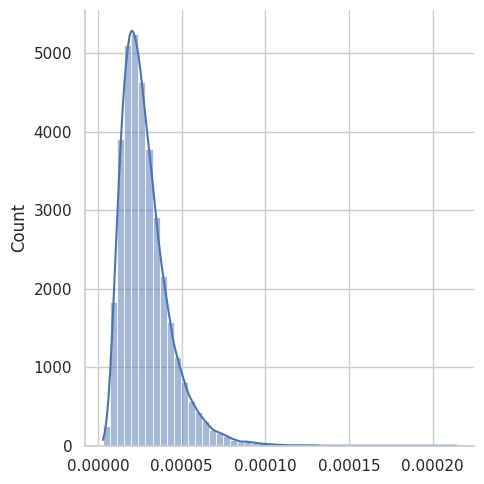

In [182]:
sns.displot(train_losses, bins=50, kde=True)

In [165]:
# Plot losses
# plt.figure(figsize=(14,6))
# plt.plot(train_losses, label='Train Reconstruction Error')
# # plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
# # plt.scatter(np.where(anomalies)[0], mse[anomalies], color='red', label='Anomalies')
# plt.title('Reconstruction Error')
# plt.ylabel('MSE')
# plt.xlabel('Time')
# plt.legend()
# plt.show()

In [183]:
max_train_losses = train_losses.max().item()
print(max_train_losses)

0.00021408803877420723


Let's consider a threshold of **0.00022** (base on max value of train set's losses above) for anomaly dection.

In [172]:
ANOMALY_THRESHOLD = 0.0003

In [185]:
test_predictions, test_losses  = predict(model, criterion, test_sequences, batch_size=batch_size)
val_predictions, val_losses = predict(model, criterion, val_sequences, batch_size=batch_size)

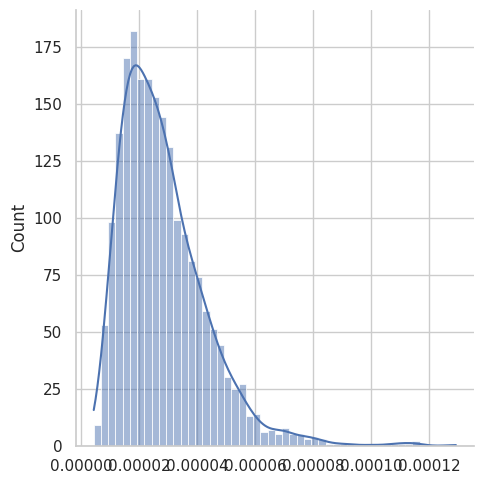

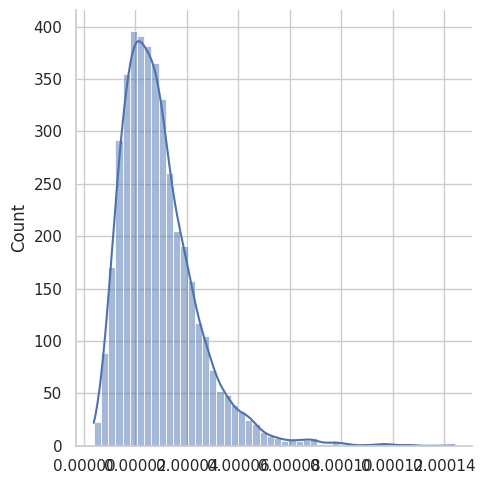

In [186]:
sns.displot(test_losses, bins=50, kde=True)
sns.displot(val_losses, bins=50, kde=True)

In [188]:
val_losses

array([2.7630222e-05, 2.1913864e-05, 1.5434573e-05, ..., 1.3420741e-05,
       1.8528772e-05, 2.9328716e-05], dtype=float32)

In [190]:
val_anomalies = val_losses[val_losses > ANOMALY_THRESHOLD]
test_anomalies = test_losses[test_losses > ANOMALY_THRESHOLD]

print(len(val_anomalies))
print(len(test_anomalies))

0
0


THERE IS NO ANOMALY DETECTED IN val set and test set for static THRESHOLD above, therefore, there is no anomaly in NORMAL cases.

In [192]:
# ax = plt.figure(figsize=(16,6)).gca()

# ax.plot(test_losses, label='Test Reconstruction Error')
# ax.plot(val_losses, label='Valid Reconstruction Error')
# # plt.plot(train_losses, label='Train Reconstruction Error')
# # plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
# # plt.scatter(np.where(anomalies)[0], mse[anomalies], color='red', label='Anomalies')
# plt.title('Normal Reconstruction Error')
# plt.ylabel('MSE')
# plt.xlabel('Time')
# plt.legend()
# plt.show()

### Generated Data vs. Real

In [199]:
def create_df(reversed_predictions):
    synthetic_data = scaler.inverse_transform(reversed_predictions)
    synthetic_df = pd.DataFrame(synthetic_data, columns=['Year', 'PROVINCE', 'Week_no', 'Count'])

    synthetic_df[['Year', 'Week_no', 'Count', 'PROVINCE']] = synthetic_df[['Year', 'Week_no', 'Count', 'PROVINCE']].round().astype(int)
    # Map back the encoded province names
    # synthetic_df['PROVINCE'] = synthetic_df['PROVINCE'].apply(lambda x: province_code_mapping.get(int(x), 'Unknown'))
    return synthetic_df

In [138]:
# Combine Train+Val+Test = Normal cases
train_prediction_reversed = reverse_windowing(train_predictions)
val_prediction_reversed = reverse_windowing(val_predictions)
test_prediction_reversed = reverse_windowing(test_predictions)
normal_predictions = torch.cat((train_prediction_reversed, val_prediction_reversed, test_prediction_reversed))

In [141]:
normal_prediction_df = create_df(normal_predictions)

In [144]:
print(f"Normal Dataframe Shape: {normal_df.shape}")
print(f"Predicted Normal Dataframe Shape: {normal_prediction_df.shape}")

Normal Dataframe Shape: (41802, 4)
Predicted Normal Dataframe Shape: (41802, 4)


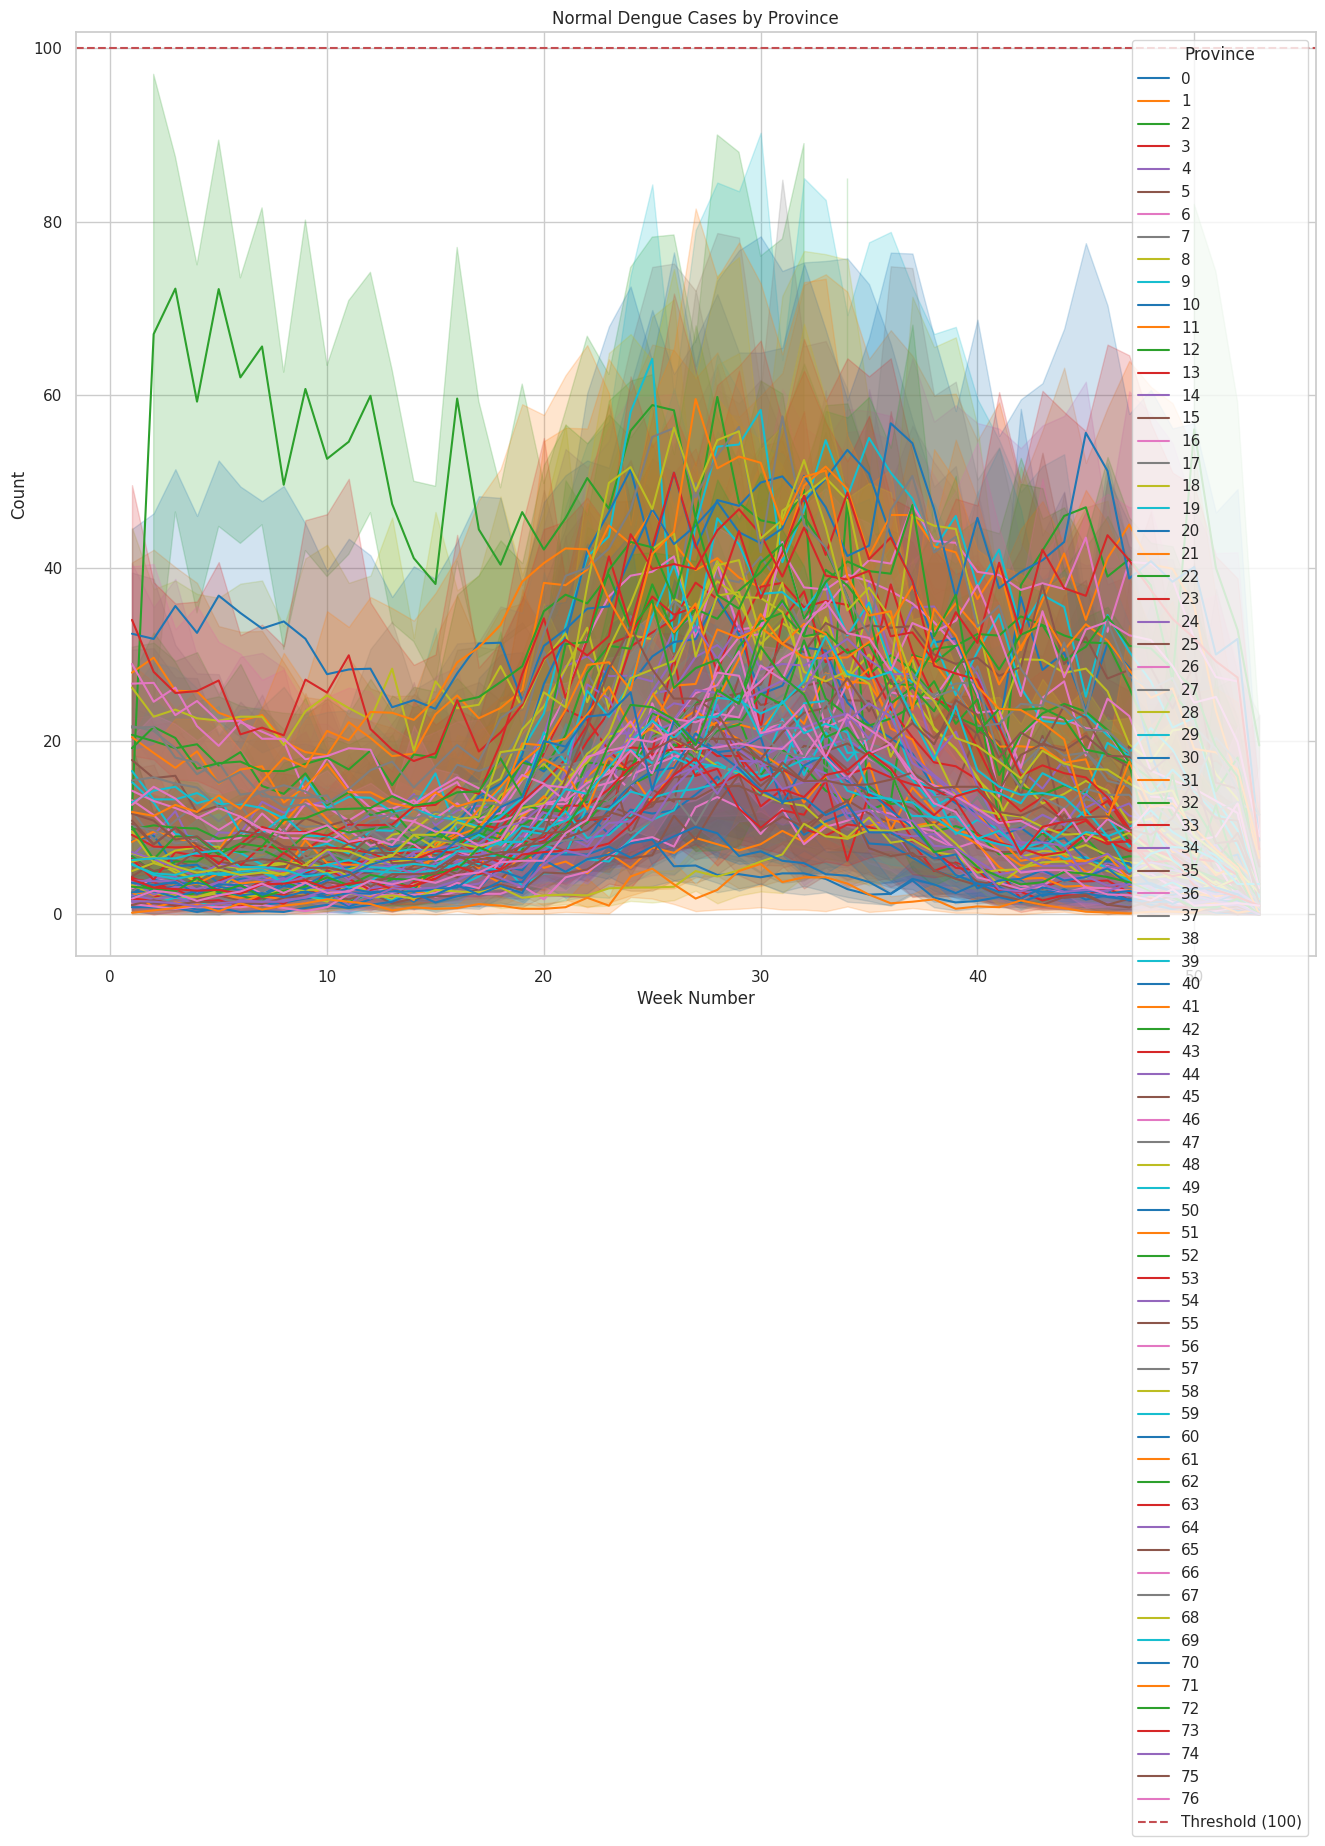

In [136]:
# Plot real data
plot_dengue(normal_df, count_threshold=COUNT_THRESHOLD, title='Normal Dengue Cases by Province')

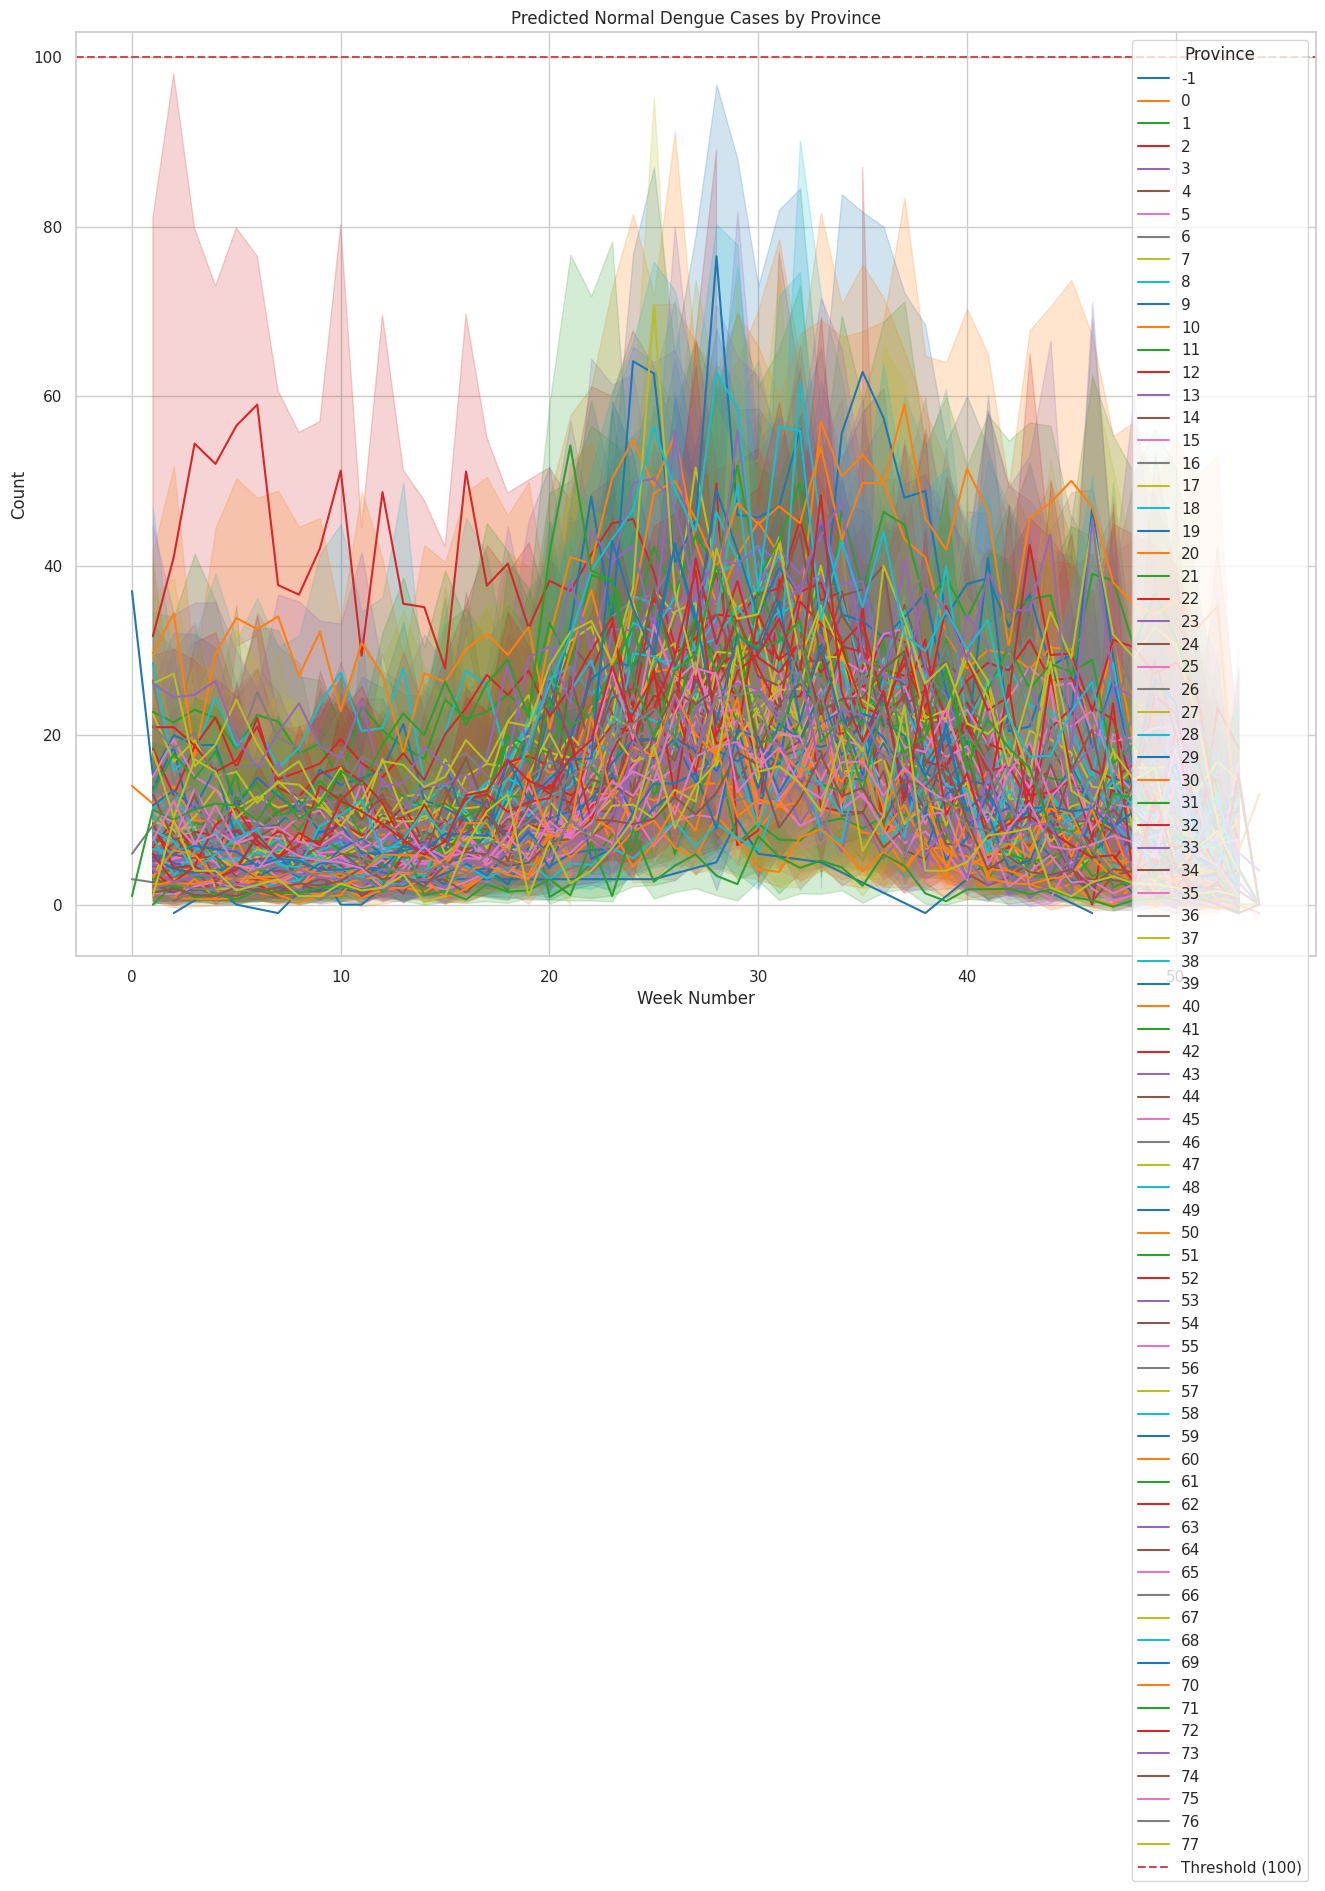

In [145]:
# Plot predicted data
plot_dengue(normal_prediction_df, count_threshold=COUNT_THRESHOLD, title='Predicted Normal Dengue Cases by Province')

### Abnormal Cases Predictions

In [201]:
abnormal_predictions, abnormal_losses = predict(model, criterion, test_abnormal_sequences)

In [202]:
print(test_abnormal_sequences.shape)
print(abnormal_predictions.shape)
print(abnormal_losses.shape)

torch.Size([1584, 4, 4])
torch.Size([1584, 4, 4])
(1584,)


In [203]:
abnormal_anomalies = abnormal_losses[abnormal_losses > ANOMALY_THRESHOLD]
print(abnormal_anomalies.shape)

(1492,)


### Let's trace back the anomalies to map the original data (Which one is abnormal!)

In [ ]:
# TODO

### Generated Data vs. Real

In [204]:
predicted_abnormal_data = reverse_windowing(abnormal_predictions)
predicted_abnormal_df = create_df(predicted_abnormal_data)

In [205]:
print(abnormal_df.shape)
print(predicted_abnormal_df.shape)

(1587, 4)
(1587, 4)


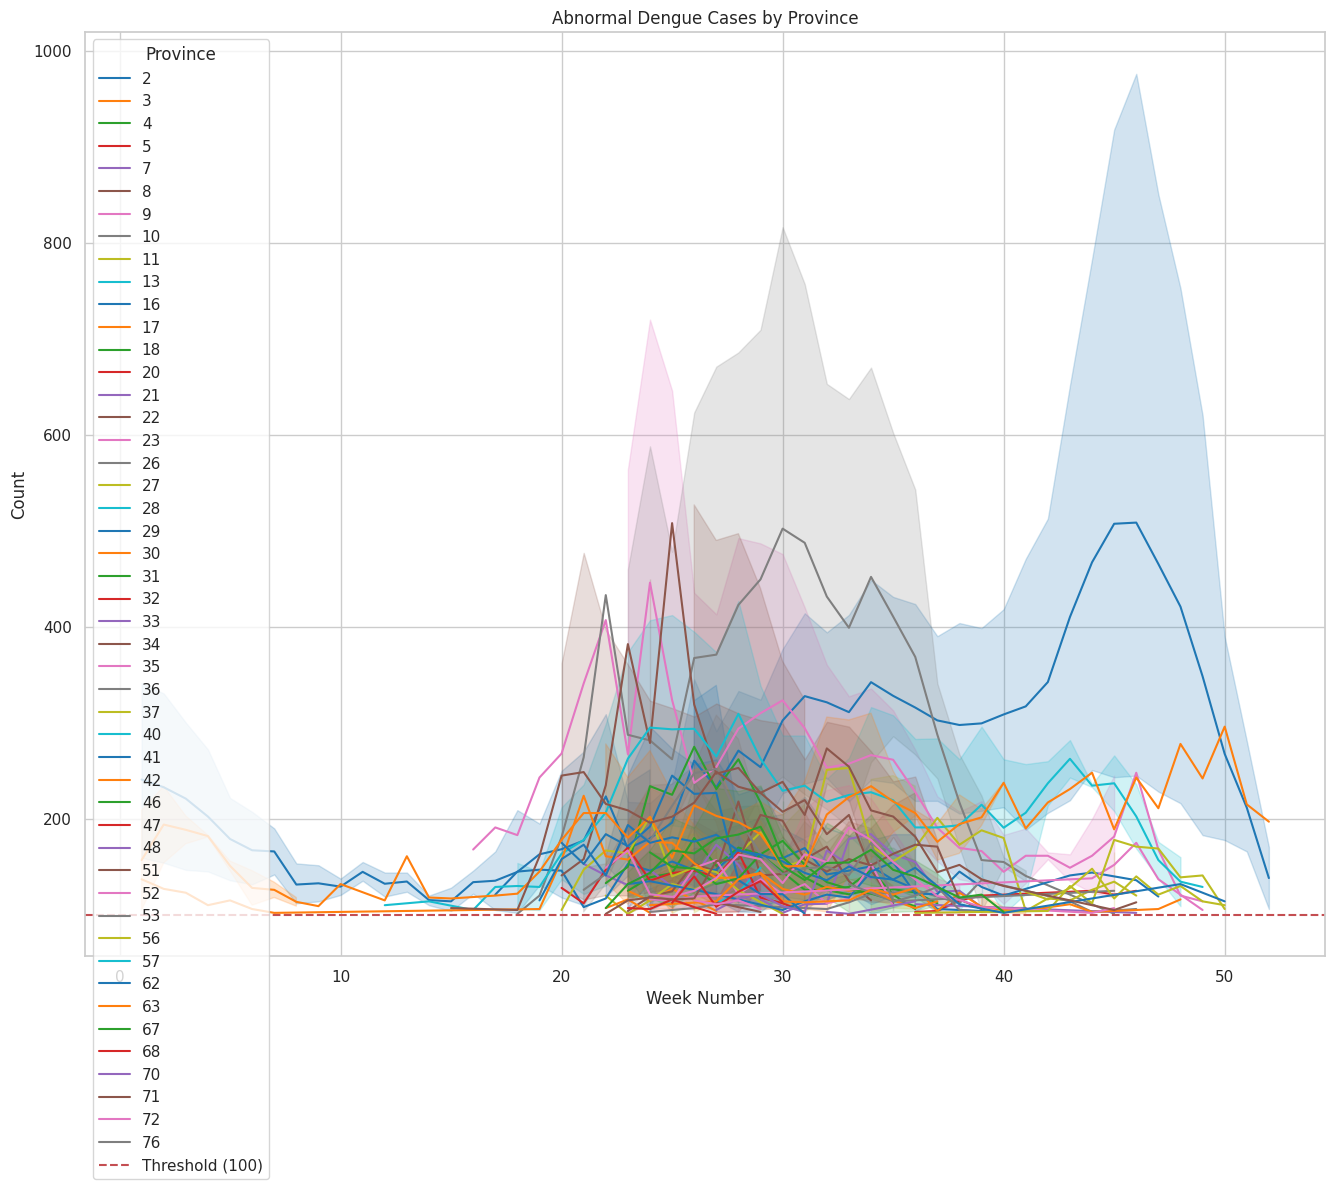

In [149]:
plot_dengue(abnormal_df, count_threshold=COUNT_THRESHOLD, title='Abnormal Dengue Cases by Province')

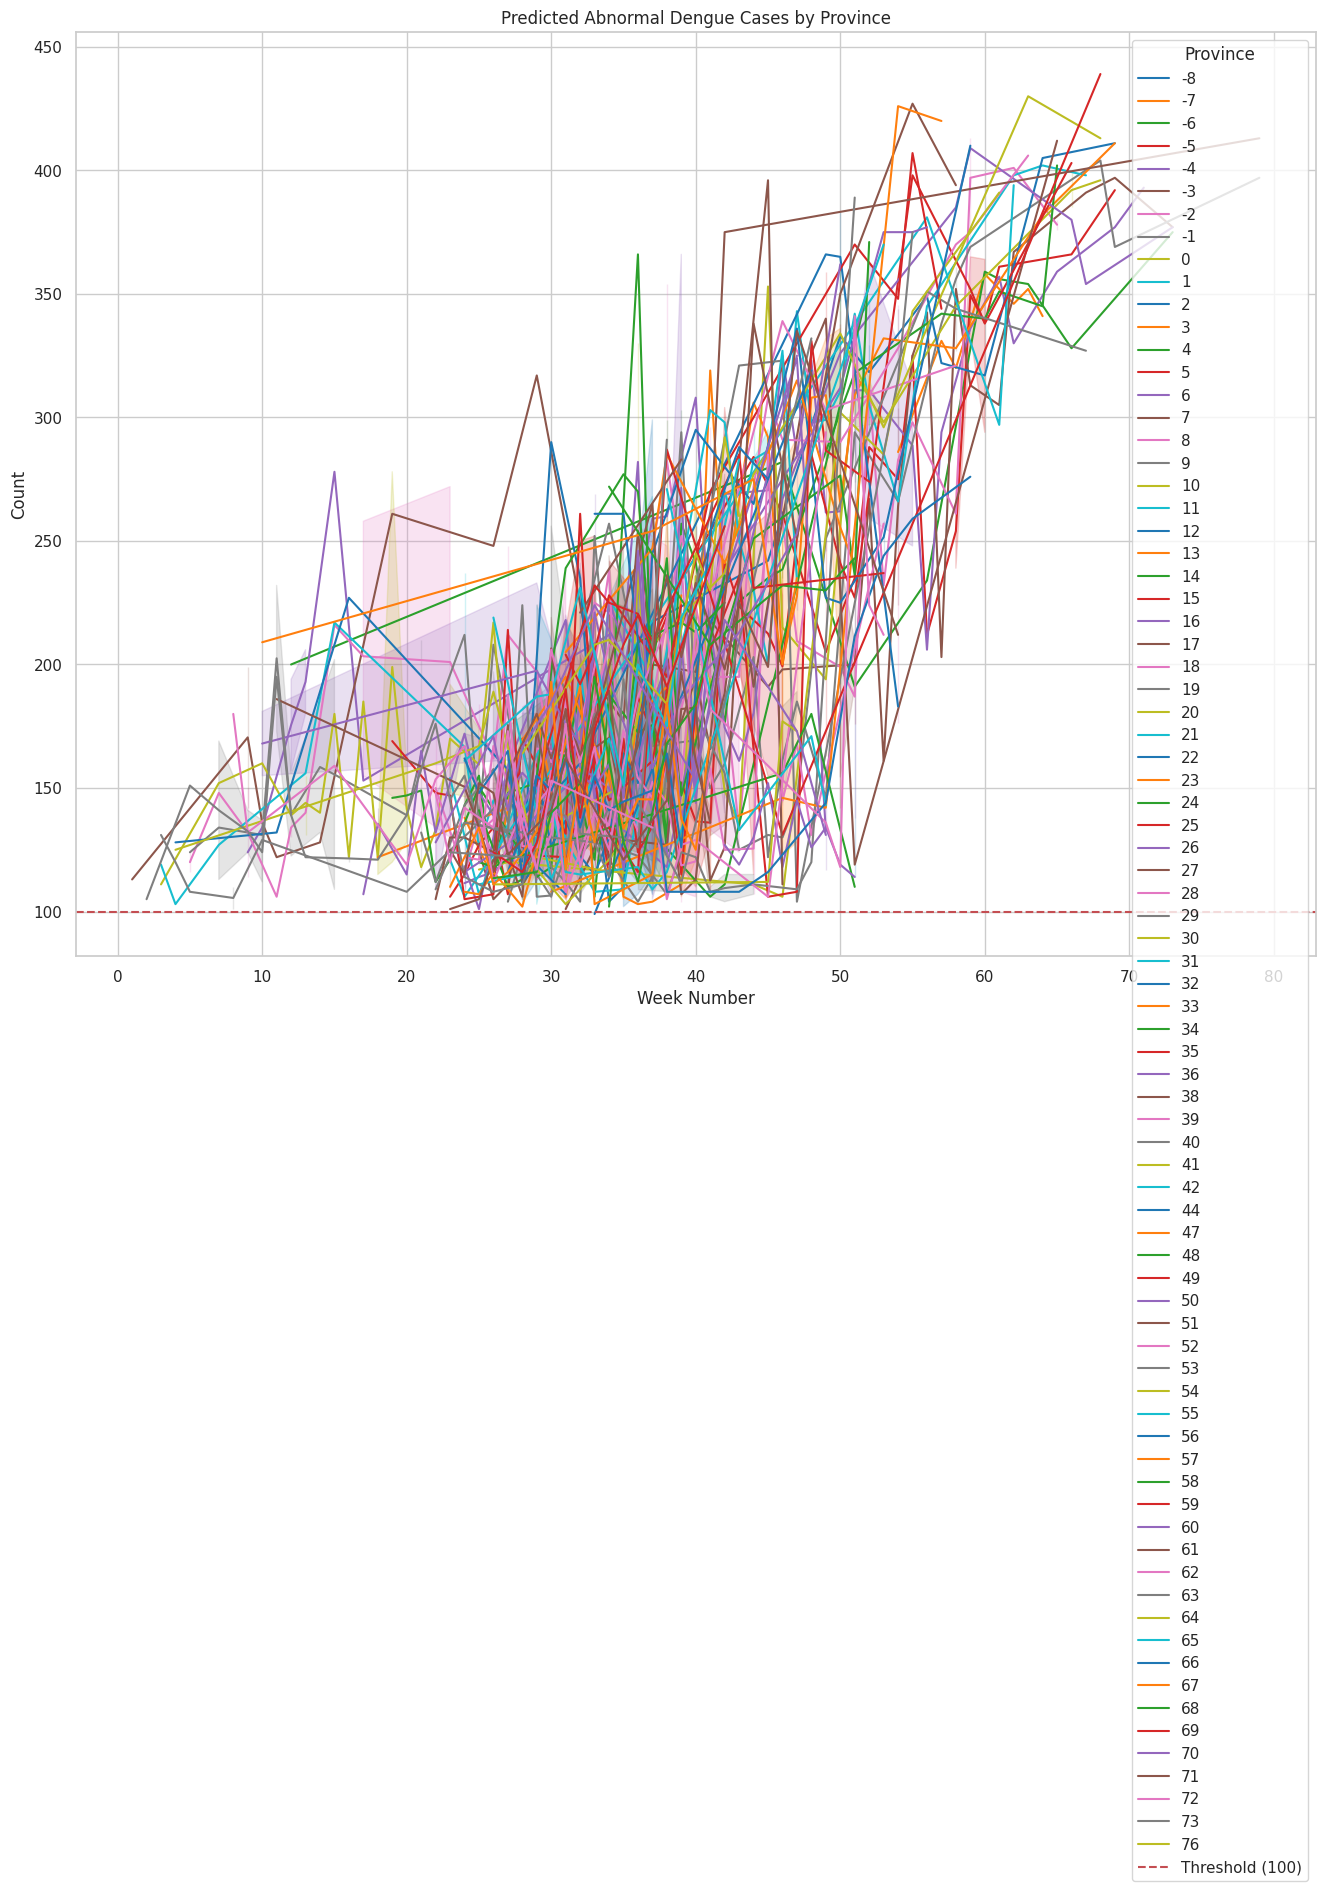

In [150]:
plot_dengue(predicted_abnormal_df, count_threshold=COUNT_THRESHOLD, title='Predicted Abnormal Dengue Cases by Province')

### References
Here are the reference to read:
- https://pmc.ncbi.nlm.nih.gov/articles/PMC10452936/ 
- https://github.com/curiousily/Getting-Things-Done-with-Pytorch/blob/master/manuscript/06.time-series-anomaly-ecg.md 